# Discovering Causal Relationships through Gradient Learning

Imagine you've collected data on student study hours, sleep patterns, and exam scores. You notice correlations between these variables, but correlation doesn't imply causation which is a fundamental challenge in data analysis. Does more studying cause better exam performance? Does sleep quality affect study efficiency? Or do other factors drive these relationships?

Unlike standard machine learning that focuses on prediction, causal inference seeks to understand the underlying mechanisms: what causes what.

Traditionally, establishing causality required controlled experiments where we manipulate variables and observe outcomes. But what if experiments are impossible, unethical, or too expensive? Can we infer causality from observational data alone?

Approaches differ from constraint-based methods (like the PC algorithm) that test conditional independence, and score-based methods that search for graph structures optimizing certain criteria. Both approaches face a fundamental hurdle: learning a Directed Acyclic Graph (DAG) is a combinatorial optimization problem with a super-exponential search space ie. there are $2^(n^2)$ possible edge configurations for n variables.

# The Challenge
## Learning Dags from data
Simplistically at it's core the problem is about finding a Directed Acyclic Graph (DAG) from a data generating process. A node would represent a variable, and the edge would represent the relationship. The edge is weighted to represent the strength of the relationship.

## Traditional Approaches and Their Limitations
Previous methods for causal discovery generally fall into two categories:
1. Constraint-Based Methods (like PC and FCI algorithms):

- Test conditional independence between variables
- Build a graph consistent with these independence relationships
- **Advantages**: Require fewer assumptions about the data distribution
- **Limitations**: Sensitive to errors in independence tests, especially with limited data

2. Score-Based Methods (like GES and various Bayesian approaches):

- Define a score function that measures how well a graph explains the data
- Search through the space of possible graphs to maximize this score
- **Advantages**: Can incorporate prior knowledge and handle uncertainty
- **Limitations**: The search space grows super-exponentially with the number of variables

Both of these class of approaches as discussed by the paper struggle with one thing: *ensuring dag acyclicity*. The space of all possible graph is large but only a fraction are acyclic.


In [1]:
import numpy as np
import networkx as nx

from utils import timing


def generate_random_dag(d, s0):
    """Generate a random DAG with d nodes and s0 expected edges."""
    # Create a random lower triangular matrix with random weights
    A = np.zeros((d, d))
    for i in range(d):
        for j in range(i):
            if np.random.rand() < s0/(d-1):
                A[j, i] = np.random.uniform(0.5, 2.0) * np.random.choice([-1, 1])

    # Randomly permute the nodes to get a random DAG
    P = np.random.permutation(np.eye(d))
    A = P.T @ A @ P

    return A

def generate_sem_data(W, n, noise_scale=1.0):
    """Generate data from a linear SEM X = XW + Z."""
    d = W.shape[0]
    I = np.eye(d)
    Z = np.random.normal(0, noise_scale, size=(n, d))

    # For NOTEARS, we need W where W[i,j] means j→i
    W_notears = W.T

    # Use matrix form: X = (I-W')^(-1)Z  (where W' is in NOTEARS convention)
    X = Z @ np.linalg.inv(I - W_notears.T)

    return X, W_notears

In [2]:
np.random.seed(42)
nodes, edges = 5, 2
samples = 1000
A = generate_random_dag(nodes, edges)
X, W_notears = generate_sem_data(A, 1000)
A

array([[ 0.        ,  0.        ,  0.        ,  1.95486478,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.98831734,  0.        ],
       [-1.92607146, -0.64996237,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [3]:
def visualize_dag(W, ax=None, title="DAG", node_color='lightblue',
                 threshold=0.01, node_size=800, seed=42, pos=None):
    """
    Visualize a DAG from its weighted adjacency matrix.

    Parameters:
    -----------
    W : array-like
        Standard adjacency matrix where W[i,j] != 0 means edge from i→j
    ax : matplotlib Axes, optional
        Axes to plot on. If None, a new figure and axes are created
    title : str, optional
        Title for the plot
    node_color : str or list, optional
        Color(s) for the nodes
    threshold : float, optional
        Threshold for considering an edge present
    node_size : int, optional
        Size of the nodes in the visualization
    seed : int, optional
        Random seed for layout if pos is None
    pos : dict, optional
        Pre-computed positions for nodes. If None, positions are computed using spring layout

    Returns:
    --------
    tuple
        (NetworkX graph, node positions dict, matplotlib Axes)
    """
    # Create a directed graph from the adjacency matrix
    G = nx.DiGraph()

    # Add nodes
    n_nodes = W.shape[0]
    G.add_nodes_from(range(n_nodes))

    # Convert to numpy if needed
    if hasattr(W, 'numpy'):
        W = W.numpy()

    # Add weighted edges where weight > threshold
    for i in range(n_nodes):
        for j in range(n_nodes):
            if abs(W[i, j]) > threshold:
                # i→j represents an edge from i to j (standard convention)
                G.add_edge(i, j, weight=float(W[i, j]))

    # Create figure if needed
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    # Compute layout if not provided
    if pos is None:
        pos = nx.spring_layout(G, seed=seed)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color,
                          alpha=0.8, ax=ax)

    # Draw edges with width proportional to weight
    edge_widths = [abs(G[u][v]['weight']) * 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7,
                         arrowsize=25, arrowstyle='-|>', connectionstyle='arc3,rad=0.2',
                         ax=ax)

    # Draw node labels
    labels = {i: str(i) for i in range(n_nodes)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_weight='bold', ax=ax)

    # Optional: draw edge weights
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    # Set title and turn off axis
    ax.set_title(title, fontsize=15)
    ax.axis('off')

    return G, pos, ax

In [4]:
visualize_dag(W_notears)

NameError: name 'plt' is not defined

The following dag represents causal relationships where the nodes are the variables we're exploring and the arrows indicate the direction to where the variable directly causes or effects the other. The edge weights represent the strength of the causal effect. A positive increase in cause increase in effect whilst a negative means increase in cause decrease in effect.

Relationships in this toy example:

- X3 has a negative effect (-1.93) on X1
- X3 has a positive effect (1.95) on X0
- X0 influences X2 with a negative effect (-1.99)
- X1 has a small negative effect (-0.65) on X2
- X4 appears isolated (no edges connecting to it)

In layman's terms this could mean
- X3 could be considered a "common cause" for X2, X3, and X0
- X4 is independent of the other variables (a confounding variable that wasn't detected or has no relationship)

This scenario is ideal for this algorithm to work because:
- It has no cycles
- Weighted edges representing the strength of causal effects
- A mix of relationships (some variables with multiple parents/children, some isolated)

## Benchmark


In [ ]:
from pgmpy.estimators import HillClimbSearch, BicScore
import pandas as pd

@timing
def run_hill_climbing(X):
    # Convert to pandas DataFrame for pgmpy
    data = pd.DataFrame(X)
    # Define scoring function
    scoring_method = BicScore(data)
    # Run Hill Climbing
    hc = HillClimbSearch(data)
    model = hc.estimate(scoring_method=scoring_method)
    # Convert to adjacency matrix
    edges = list(model.edges())
    n = X.shape[1]
    W_est = np.zeros((n, n))
    for i, j in edges:
        W_est[int(j), int(i)] = 1  # Adjust indices if needed

    return W_est

W_est_hill_climbing, time_taken_hill_climbing = run_hill_climbing(X)

## NOTEARS
NOTEARS (NonParametric Estimation of Acyclic diREcted graphS) introduced a remarkably elegant solution: reformulate the acyclicity constraint as a differentiable function of the weight matrix W:
$$
h(W) = tr(e^{(W \cdot W)}) - d = 0
$$
where:
- tr() is the trace operator (sum of diagonal elements)
- $e^{(W \cdot W)}$ is the matrix exponential of the Hadamard element-wise product
- d is the number of variables

In [57]:
import jax
from jax import numpy as jnp
import scipy.optimize as sopt
from functools import partial
from jax import jit, value_and_grad

# === Core Mathematical Functions ===

@jit
def h_acyclic(W):
    """Calculate the acyclicity constraint value."""
    d = W.shape[0]
    E = jax.scipy.linalg.expm(W * W)
    return jnp.trace(E) - d

@jit
def l2_loss(X, W):
    """Calculate L2 loss between data X and model X@W."""
    M = X @ W
    R = X - M
    return 0.5 / X.shape[0] * jnp.sum(R ** 2)

@partial(jit, static_argnums=(1,))
def _adj(w, d):
    """Convert doubled variables [w_pos, w_neg] to weight matrix W = w_pos - w_neg."""
    d_squared = d * d
    w_pos = w[:d_squared].reshape((d, d))
    w_neg = w[d_squared:].reshape((d, d))
    return w_pos - w_neg

@partial(jit, static_argnums=(2,))
def augmented_lagrangian(w, X, d, alpha, rho, lambda1):
    """Compute the augmented Lagrangian objective."""
    W = _adj(w, d)
    loss = l2_loss(X, W)
    h = h_acyclic(W)
    return loss + 0.5 * rho * h * h + alpha * h + lambda1 * jnp.sum(w)

# Create compiled value_and_grad function
aug_lagrangian_with_grad = value_and_grad(augmented_lagrangian, argnums=0)
aug_lagrangian_with_grad = partial(jit, static_argnums=(2,))(aug_lagrangian_with_grad)

# === Helper Functions ===

def create_dag_bounds(d):
    """Create bounds for the optimization variables."""
    bounds = []
    for k in range(2):  # For w_pos and w_neg
        for i in range(d):
            for j in range(d):
                if i == j:
                    bounds.append((0, 0))  # No self-loops
                else:
                    bounds.append((0, None))  # Non-negative weights
    return bounds

def create_scipy_wrapper(w, X, d, alpha, rho, lambda1):
    """Create a wrapper function for scipy optimizer."""
    def scipy_obj_and_grad(w_np):
        w_jax = jnp.array(w_np)
        obj, grad = aug_lagrangian_with_grad(w_jax, X, d, alpha, rho, lambda1)
        return float(obj), np.array(grad)
    return scipy_obj_and_grad

def optimize_weights(w_est, X, d, alpha, rho, lambda1, bounds):
    """Perform one step of L-BFGS-B optimization."""
    # Convert to numpy for scipy
    w_np = np.array(w_est)

    # Create the objective function wrapper
    obj_func = create_scipy_wrapper(w_est, X, d, alpha, rho, lambda1)

    # Run L-BFGS-B optimization
    result = sopt.minimize(
        obj_func, w_np, method='L-BFGS-B',
        jac=True, bounds=bounds
    )

    # Return JAX array
    return jnp.array(result.x)

def threshold_weights(W, threshold):
    """Apply thresholding to remove small edges."""
    return jnp.where(jnp.abs(W) < threshold, 0, W)

# === Main NOTEARS Algorithm ===

def notears_linear(X, lambda1=0.1, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """
    Learn a DAG from data using the NOTEARS algorithm.

    Args:
        X (ndarray): [n, d] data matrix
        lambda1 (float): L1 regularization parameter
        max_iter (int): Maximum number of dual ascent steps
        h_tol (float): Exit if |h(W)| <= h_tol
        rho_max (float): Exit if rho >= rho_max
        w_threshold (float): Remove edges with |weight| < threshold

    Returns:
        W_est (ndarray): [d, d] estimated DAG
    """
    # Setup
    n, d = X.shape
    X = X - jnp.mean(X, axis=0)  # Center the data

    # Initialize parameters
    w_est = jnp.zeros(2 * d * d)  # [w_pos, w_neg]
    rho, alpha, h = 1.0, 0.0, jnp.inf

    # Create bounds for optimization
    bounds = create_dag_bounds(d)

    # Augmented Lagrangian optimization
    for i in range(max_iter):
        # Inner optimization
        w_new = None
        inner_converged = False

        while rho < rho_max and not inner_converged:
            # Optimize weights
            w_new = optimize_weights(w_est, X, d, alpha, rho, lambda1, bounds)

            # Check acyclicity
            W_new = _adj(w_new, d)
            h_new = h_acyclic(W_new)

            # Update penalty parameter if needed
            if h_new > 0.25 * h:
                rho *= 10
            else:
                inner_converged = True

        # Update estimates
        w_est = w_new
        h = h_acyclic(_adj(w_est, d))
        alpha += rho * h

        # Log progress
        print(f"Iteration {i}: h={h:.6e}, rho={rho:.2e}")

        # Check convergence
        if h <= h_tol or rho >= rho_max:
            break

    # Final processing
    W_est = _adj(w_est, d)

    # Thresholding
    W_est = jnp.where(jnp.abs(W_est) < w_threshold, 0, W_est)

    print(f"Final h(W): {h_acyclic(W_est):.6e}")

    # Transpose to get standard adjacency matrix where W[i,j]≠0 means i→j
    W_est = W_est.T

    return W_est



In [65]:
def plot_dag_comparison(W_true, W_est, figsize=(12, 5), threshold=0.01, transpose=True):
    """
    Plot the true and estimated DAGs side by side.

    Parameters:
    -----------
    W_true : array-like
        True weighted adjacency matrix
    W_est : array-like
        Estimated weighted adjacency matrix
    figsize : tuple, optional
        Figure size
    threshold : float, optional
        Threshold for considering an edge present
    transpose : bool, optional
        Whether to transpose the adjacency matrices (True for NOTEARS convention)

    Returns:
    --------
    tuple
        (figure, axes, graph positions dict)
    """
    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot true DAG
    G_true, pos, _ = visualize_dag(W_true, ax=axes[0], title="True DAG",
                                 node_color='lightblue', threshold=threshold,
                                 )

    # Plot estimated DAG using same node positions
    G_est, _, _ = visualize_dag(W_est, ax=axes[1], title="Estimated DAG",
                              node_color='lightgreen', threshold=threshold,
                              pos=pos)

    plt.tight_layout()
    return fig, axes, pos

Iteration 0: h=4.569783e-01, rho=1.00e+00
Iteration 1: h=4.062176e-02, rho=1.00e+02
Iteration 2: h=8.110046e-03, rho=1.00e+03
Iteration 3: h=1.806259e-03, rho=1.00e+04
Iteration 4: h=3.643036e-04, rho=1.00e+05
Iteration 5: h=9.059906e-05, rho=1.00e+06
Iteration 6: h=1.716614e-05, rho=1.00e+07
Iteration 7: h=9.536743e-07, rho=1.00e+09
Iteration 8: h=9.536743e-07, rho=1.00e+16
Final h(W): 0.000000e+00


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'True DAG'}>,
        <Axes: title={'center': 'Estimated DAG'}>], dtype=object),
 {0: array([0.12251029, 0.49037805]),
  1: array([0.57577586, 0.09884114]),
  2: array([-0.35022361, -1.        ]),
  3: array([-0.75018389,  0.11492044]),
  4: array([0.40212136, 0.29586037])})

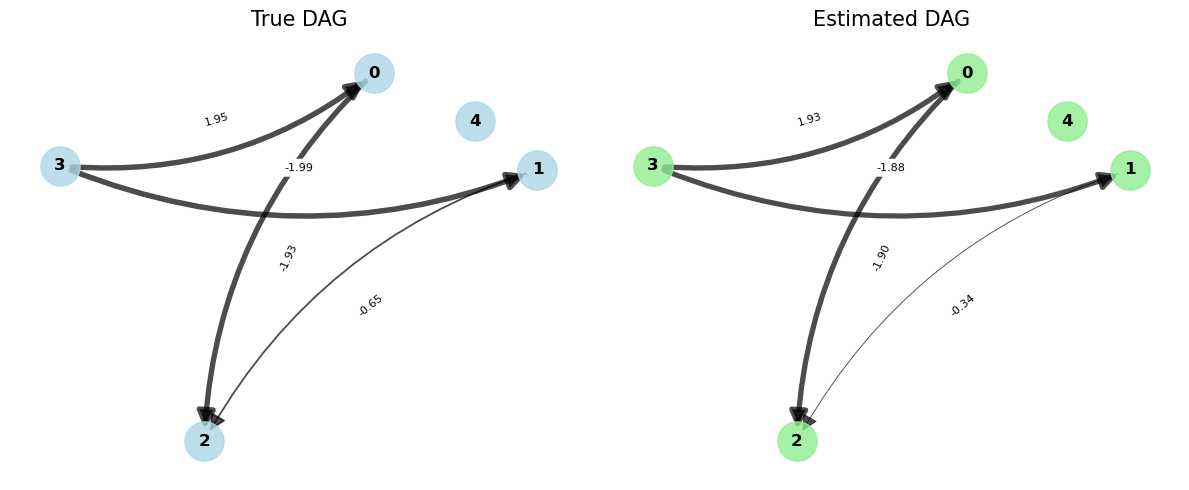

In [82]:
lambda1=0.05
loss_type='l2'
max_iter=100
h_tol=1e-8
rho_max=1e+16
w_threshold=0.3
estimated_A = notears_linear(X, lambda1, max_iter, h_tol, rho_max, w_threshold)
plot_dag_comparison(W_notears, estimated_A)

{'precision': np.float64(1.0),
 'recall': np.float64(1.0),
 'f1': np.float64(1.0),
 'true_edges': np.int64(4),
 'est_edges': np.int64(4),
 'true_positive': np.int64(4),
 'false_positive': np.int64(0),
 'false_negative': np.int64(0),
 'true_negative': np.int64(21),
 'shd': np.float64(0.0),
 'additions': np.int64(0),
 'deletions': np.int64(0),
 'reversals': np.float64(0.0)}

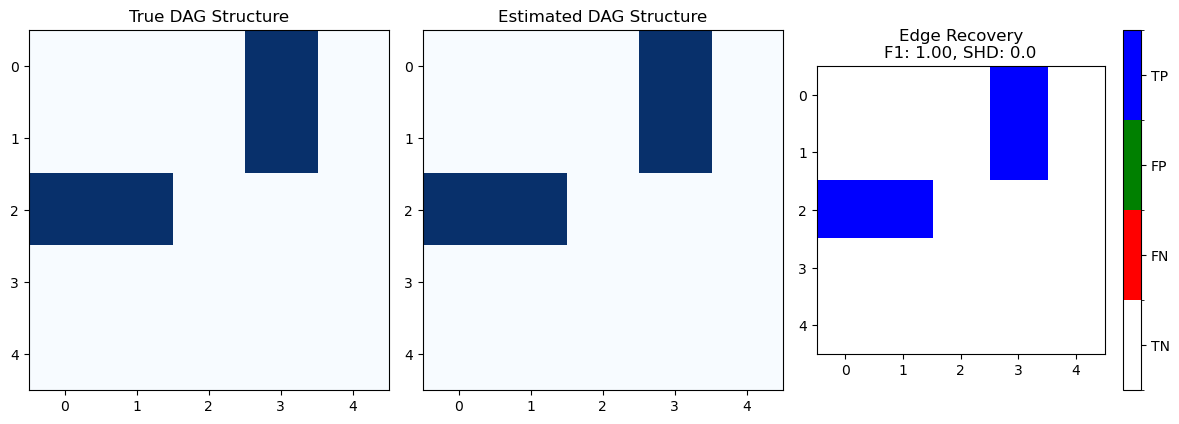

In [83]:
from matplotlib import pyplot as plt

def evaluate_reconstruction(W_true, W_est, threshold=0.01, figsize=(12, 4),
                          show_plot=True, transpose=True):
    """
    Evaluate and visualize the reconstruction quality of the estimated DAG.

    Parameters:
    -----------
    W_true : array-like
        True weighted adjacency matrix
    W_est : array-like
        Estimated weighted adjacency matrix
    threshold : float, optional
        Threshold for considering an edge present
    figsize : tuple, optional
        Figure size for the plot
    show_plot : bool, optional
        Whether to show the plot
    transpose : bool, optional
        Whether to transpose the adjacency matrices (True for NOTEARS convention)

    Returns:
    --------
    dict
        Dictionary with evaluation metrics
    """
    # Ensure arrays are in numpy format
    W_true = np.array(W_true)
    W_est = np.array(W_est)

    # Transpose if using NOTEARS convention
    if transpose:
        W_true = W_true.T
        W_est = W_est.T

    # Threshold adjacency matrices
    true_edges = np.abs(W_true) > threshold
    est_edges = np.abs(W_est) > threshold

    # Compute evaluation metrics
    n_true_edges = np.sum(true_edges)
    n_est_edges = np.sum(est_edges)

    # True positive, false positive, false negative
    tp = np.sum((true_edges) & (est_edges))
    fp = np.sum((~true_edges) & (est_edges))
    fn = np.sum((true_edges) & (~est_edges))
    tn = np.sum((~true_edges) & (~est_edges))

    # Compute metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Compute SHD (Structural Hamming Distance)
    # Count edge additions, deletions, and reversals
    additions = np.sum((~true_edges) & (est_edges))
    deletions = np.sum((true_edges) & (~est_edges))

    # Identify edge reversals
    potential_reversals = np.zeros_like(true_edges)
    for i in range(W_true.shape[0]):
        for j in range(W_true.shape[0]):
            if true_edges[i, j] and est_edges[j, i]:
                potential_reversals[i, j] = 1

    # Avoid double-counting bidirectional edges as reversals
    reversals = np.sum(potential_reversals) - np.sum(potential_reversals & potential_reversals.T) / 2

    # SHD is the sum of additions, deletions and reversals
    shd = additions + deletions + reversals

    # Create result dictionary
    results = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true_edges": n_true_edges,
        "est_edges": n_est_edges,
        "true_positive": tp,
        "false_positive": fp,
        "false_negative": fn,
        "true_negative": tn,
        "shd": shd,
        "additions": additions,
        "deletions": deletions,
        "reversals": reversals
    }

    # Visualization
    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=figsize)

        # Create binary matrices for visualization
        axes[0].imshow(true_edges.astype(int), cmap='Blues')
        axes[0].set_title("True DAG Structure")

        axes[1].imshow(est_edges.astype(int), cmap='Blues')
        axes[1].set_title("Estimated DAG Structure")

        # Create a difference matrix
        diff = np.zeros_like(true_edges, dtype=int)
        diff[true_edges & est_edges] = 3  # True positive
        diff[~true_edges & est_edges] = 2  # False positive
        diff[true_edges & ~est_edges] = 1  # False negative

        cmap = plt.cm.colors.ListedColormap(['white', 'red', 'green', 'blue'])
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

        im = axes[2].imshow(diff, cmap=cmap, norm=norm)
        axes[2].set_title(f"Edge Recovery\nF1: {f1:.2f}, SHD: {shd}")

        # Add colorbar with labels
        cbar = fig.colorbar(im, ax=axes[2], ticks=[0, 1, 2, 3])
        cbar.set_ticklabels(['TN', 'FN', 'FP', 'TP'])

        plt.tight_layout()

    return results

evaluate_reconstruction(W_notears, estimated_A)